# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       #Augumentation
                                       transforms.RandomRotation(10),
                                       transforms.RandomHorizontalFlip(p=0.2),
                                       transforms.RandomChoice([
                                           transforms.ColorJitter(hue=0.1),
                                           transforms.ColorJitter(brightness=0.2),
                                           transforms.ColorJitter(saturation=0.2),
                                           transforms.ColorJitter(contrast=0.2),
                                       ]),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

data_dir = 'landmark_images/'

train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

For training:
- I randomly cropped images to 224x224 because the Vgg nets use such size. 
- I randomly rotated images by 10 degrees because there could be some small angle random rotations in the image space when people took pictures. 
- I applied the color normalization according to imagenet data. It is a common practice.

For testing:
- I only resized images to 255x255 and center cropped them to 224x224 to match the training images' size.
- Color normalization was applied to match training images too.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

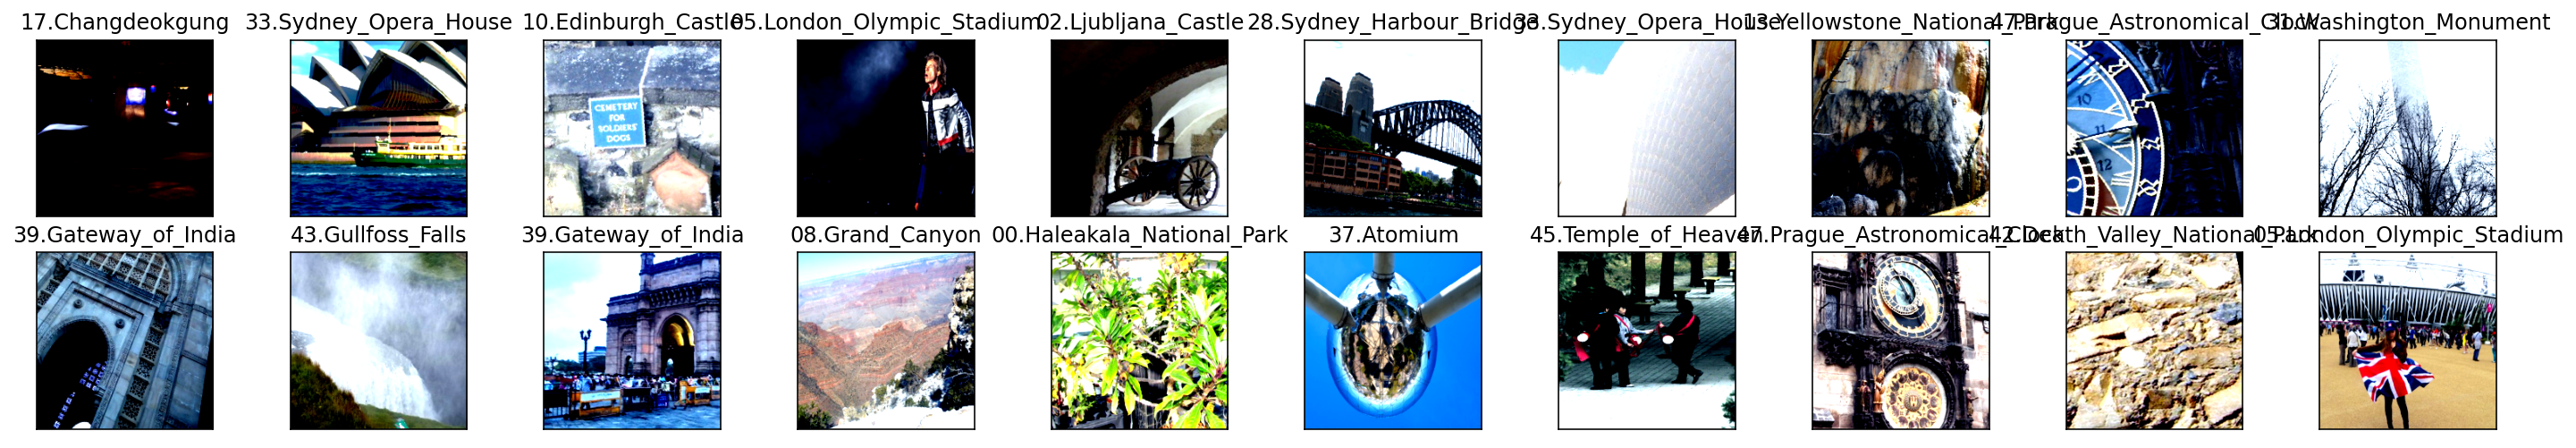

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
## TODO: visualize a batch of the train data loader
# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)




### Initialize use_cuda variable

In [2]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [3]:
import torch.optim as optim
import torch.nn as nn

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64x28x28 -> 2500)
        self.fc1 = nn.Linear(64 * 28 * 28, 2500)
        # linear layer (2500 -> 50)
        self.fc2 = nn.Linear(2500, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        # batchnorms
        self.bn_conv1 = nn.BatchNorm2d(16)
        self.bn_conv2 = nn.BatchNorm2d(32)
        self.bn_conv3 = nn.BatchNorm2d(64)
        self.bn_fc1 = nn.BatchNorm1d(2500)
        self.bn_fc2 = nn.BatchNorm1d(50)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn_conv1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn_conv2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn_conv3(x)
        
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=2500, bias=True)
  (fc2): Linear(in_features=2500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (bn_conv1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_conv3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc1): BatchNorm1d(2500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  I took the design concept from the CNN-CIFA10 exercises I learned from the course. Each layer Reduces the image size by 1/2 while increasing the depth twice. I put 3 layers of convolutional and corresponding fully connected layers. I did try one more convolutional layer, but the results got worse.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [22]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [23]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
        '''
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        '''
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)
        

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(40, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_custom_init.pt')

/tmp/ipykernel_615/596994081.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Epoch: 1 	Training Loss: 3.890087 	Validation Loss: 3.593707
Validation loss decreased (inf --> 3.593707).  Saving model ...
Epoch: 2 	Training Loss: 3.538272 	Validation Loss: 3.435149
Validation loss decreased (3.593707 --> 3.435149).  Saving model ...
Epoch: 3 	Training Loss: 3.428586 	Validation Loss: 3.404295
Validation loss decreased (3.435149 --> 3.404295).  Saving model ...
Epoch: 4 	Training Loss: 3.328200 	Validation Loss: 3.299371
Validation loss decreased (3.404295 --> 3.299371).  Saving model ...
Epoch: 5 	Training Loss: 3.264335 	Validation Loss: 3.237005
Validation loss decreased (3.299371 --> 3.237005).  Saving model ...
Epoch: 6 	Training Loss: 3.209698 	Validation Loss: 3.277050
Epoch: 7 	Training Loss: 3.151071 	Validation Loss: 3.145437
Validation loss decreased (3.237005 --> 3.145437).  Saving model ...
Epoch: 8 	Training Loss: 3.113933 	Validation Loss: 3.115171
Validation loss decreased (3.145437 --> 3.115171).  Saving model ...
Epoch: 9 	Training Loss: 3.089143 

**Comment** 
- I tried to train the same model with such customized weight initialization for 40 epochs, and found the test accuracy is 42%. It is better than the 37% test accuracy when the default weight initialization was used.

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [45]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.910329 	Validation Loss: 3.904913
Validation loss decreased (inf --> 3.904913).  Saving model ...
Epoch: 2 	Training Loss: 3.870912 	Validation Loss: 3.861043
Validation loss decreased (3.904913 --> 3.861043).  Saving model ...
Epoch: 3 	Training Loss: 3.813156 	Validation Loss: 3.798627
Validation loss decreased (3.861043 --> 3.798627).  Saving model ...
Epoch: 4 	Training Loss: 3.744964 	Validation Loss: 3.730747
Validation loss decreased (3.798627 --> 3.730747).  Saving model ...
Epoch: 5 	Training Loss: 3.675109 	Validation Loss: 3.693194
Validation loss decreased (3.730747 --> 3.693194).  Saving model ...
Epoch: 6 	Training Loss: 3.624869 	Validation Loss: 3.650666
Validation loss decreased (3.693194 --> 3.650666).  Saving model ...
Epoch: 7 	Training Loss: 3.575644 	Validation Loss: 3.594350
Validation loss decreased (3.650666 --> 3.594350).  Saving model ...
Epoch: 8 	Training Loss: 3.497371 	Validation Loss: 3.573383
Validation loss decreased (3.59435

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
model_scratch.load_state_dict(torch.load('model_custom_init.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.144731


Test Accuracy: 46% (577/1250)


__Comment__: Xavier weight initialization and batch normalization improved the test accuracy to 46%.

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [29]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [30]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [36]:
## TODO: Specify model architecture
from torchvision import models
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Replace the fully connected layers.
# n_inputs = 4096
n_inputs = model_transfer.classifier[6].in_features

last_layer = nn.Linear(n_inputs, 50)
model_transfer.classifier[6] = last_layer
'''
model_transfer.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 512),
                                             nn.ReLU(),
                                             nn.Dropout(0.2),
                                             nn.Linear(512, 50))
'''
# check to see that your last layer produces the expected number of outputs


print(model_transfer.classifier[6].out_features)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
- I used Vgg16 as the transfer learning sessions of the course. To this day is it still considered to be an excellent vision model as an feature extractor. Vgg16 worked well for image classification problem, and this project tries to solve an image classificatin problem too.
- I just need to modify the final classifier layer according to the project's classes numbers.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs = 40
train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
      criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

KeyboardInterrupt: 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [54]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.773779


Test Accuracy: 80% (1002/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [57]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    
    input = test_transforms(img).unsqueeze(0)    
    if use_cuda:
        input = input.cuda()
        
    model_transfer.eval()
    output = model_transfer(input)
    top_values, top_idx = output.topk(k)

    top_classes = [train_data.classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '30.Brooklyn_Bridge',
 '06.Niagara_Falls',
 '03.Dead_Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

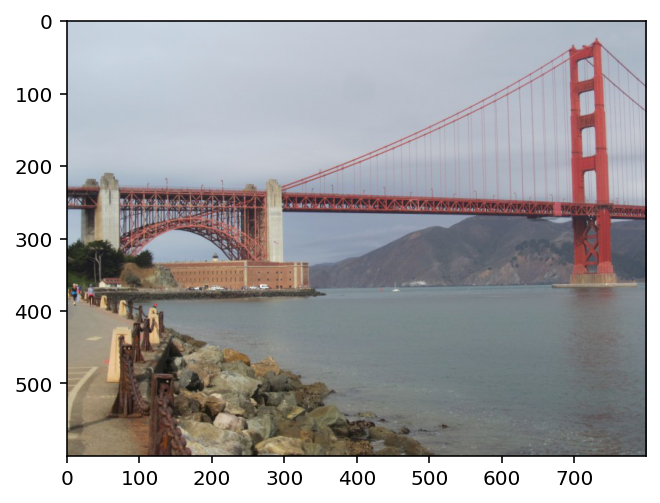

Groundtruth Label: 09.Golden_Gate_Bridge
Predicted Label from high to low probablity:
 09.Golden_Gate_Bridge, 38.Forth_Bridge, 30.Brooklyn_Bridge


In [64]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark prediction
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    print(f"Groundtruth Label: {img_path.split('/')[-2]}")
    print(f"Predicted Label from high to low probablity:\n {predicted_landmarks[0]}, {predicted_landmarks[1]}, {predicted_landmarks[2]}")

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__
The output is better than I expected because the description mentioned 60% as the passing threshold. That sort of set my expection.

some thoughts of improvement.
- Fine tune the hyper parameters such as the learning rate.
- Add more agumentation for training images, such as random chioce of color jittering.
- Add more training images for classes that show lower test accuracy.

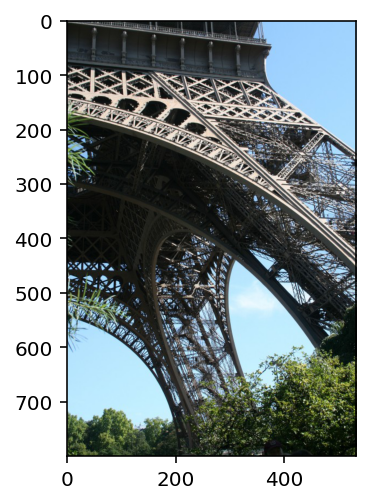

Groundtruth Label: 16.Eiffel_Tower
Predicted Label from high to low probablity:
 16.Eiffel_Tower, 38.Forth_Bridge, 28.Sydney_Harbour_Bridge


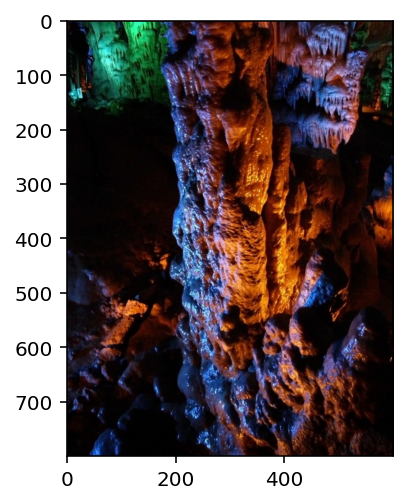

Groundtruth Label: 24.Soreq_Cave
Predicted Label from high to low probablity:
 24.Soreq_Cave, 12.Kantanagar_Temple, 34.Great_Barrier_Reef


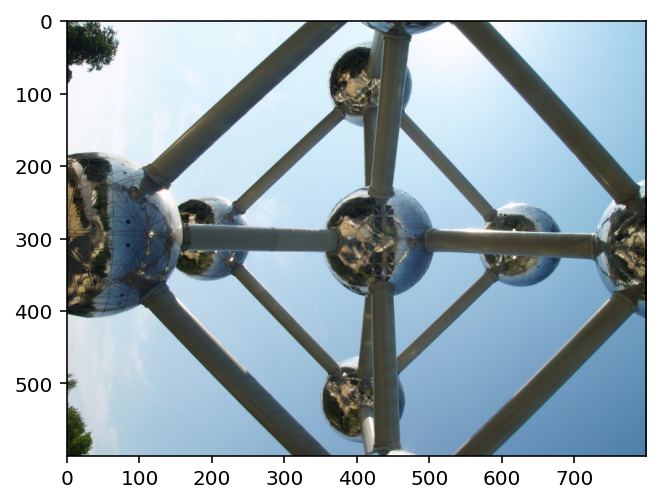

Groundtruth Label: 37.Atomium
Predicted Label from high to low probablity:
 37.Atomium, 16.Eiffel_Tower, 04.Wroclaws_Dwarves


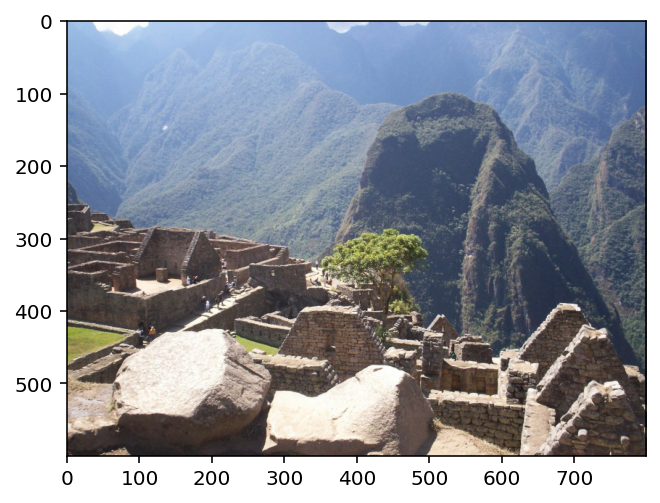

Groundtruth Label: 41.Machu_Picchu
Predicted Label from high to low probablity:
 41.Machu_Picchu, 46.Great_Wall_of_China, 10.Edinburgh_Castle


In [65]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('images/test/16.Eiffel_Tower/3828627c8730f160.jpg')
suggest_locations('images/test/24.Soreq_Cave/18dbbad48a83a742.jpg')
suggest_locations('images/test/37.Atomium/5ecb74282baee5aa.jpg')
suggest_locations('images/test/41.Machu_Picchu/4336abf3179202f2.jpg')